#The Summative project gives you the opportunity to apply the machine learning techniques you have learned in the introduction to the Machine Learning Module to a real-world problem.

You should identify a problem that is meaningful to you and aligns with your personal interests, such as healthcare, education, agriculture, sustainability, or finance. Your project should demonstrate your ability to apply both traditional machine learning and deep learning approaches, conduct experiments, and communicate your findings clearly.
You must select a dataset that reflects your chosen problem. Datasets from sklearn or keras are not allowed; your dataset should be original or obtained from open sources outside these libraries.
Your project should include a pipeline that compares traditional machine learning approaches using Scikit-learn with deep learning approaches using TensorFlow (Sequential and Functional APIs, tf.data API).
Conduct multiple experiments and present your results clearly, including insights on model performance and dataset limitations.

#Importing essential libraries and setting random seeds for reproducibility

In [2]:
# Imports and seeds
import os, random, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("crest")
pd.set_option('display.max_columns', None)



#create result folders, metric functions, and an experiment logger

In [3]:
# Helpers, OHE compatibility, output folders, plotting helpers
import sklearn
from packaging import version

ohe_kwargs = {'handle_unknown': 'ignore'}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False

OUTDIR = Path("results"); MODELS_DIR = OUTDIR / "models"
OUTDIR.mkdir(exist_ok=True); MODELS_DIR.mkdir(parents=True, exist_ok=True)
EXPERIMENTS_CSV = OUTDIR / "experiments.csv"

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
def mape(a,b): return float(np.mean(np.abs((a-b)/(a+1e-9))) * 100)
def evaluate_regression(y_true,y_pred):
    return {"RMSE": rmse(y_true,y_pred),
            "MAE": float(mean_absolute_error(y_true,y_pred)),
            "R2": float(r2_score(y_true,y_pred)),
            "MAPE": mape(y_true,y_pred)}

def log_experiment(row: dict):
    df_row = pd.DataFrame([row])
    if EXPERIMENTS_CSV.exists():
        pd.concat([pd.read_csv(EXPERIMENTS_CSV), df_row], ignore_index=True).to_csv(EXPERIMENTS_CSV, index=False)
    else:
        df_row.to_csv(EXPERIMENTS_CSV, index=False)

def plot_pred_vs_actual(y_true,y_pred,title="Pred vs Actual"):
    plt.figure(figsize=(5,5)); plt.scatter(y_true,y_pred,s=8,alpha=0.5)
    mn, mx = min(np.min(y_true),np.min(y_pred)), max(np.max(y_true),np.max(y_pred))
    plt.plot([mn,mx],[mn,mx],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title); plt.show()

def plot_residuals(y_true,y_pred,title="Residuals"):
    resid = y_true - y_pred
    plt.figure(figsize=(6,3)); sns.histplot(resid,bins=50,kde=True); plt.title(title+" (hist)"); plt.show()
    plt.figure(figsize=(6,3)); plt.scatter(y_pred,resid,s=6,alpha=0.5); plt.axhline(0,color='r',linestyle='--')
    plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title(title+" (vs predicted)"); plt.show()

def plot_nn_learning_curve(history,title="NN Learning Curve"):
    if history is None: return
    hist = history.history
    if 'root_mean_squared_error' in hist:
        plt.plot(hist['root_mean_squared_error'], label='train_rmse')
        if 'val_root_mean_squared_error' in hist: plt.plot(hist['val_root_mean_squared_error'], label='val_rmse')
    else:
        plt.plot(np.sqrt(hist['loss']), label='train_rmse_approx')
        if 'val_loss' in hist: plt.plot(np.sqrt(hist['val_loss']), label='val_rmse_approx')
    plt.xlabel('epoch'); plt.ylabel('RMSE'); plt.title(title); plt.legend(); plt.show()


#Load the dataset (yield_df.csv) and perform minimal cleaning (drop unnamed index columns).

In [4]:
# Load dataset and fix duplicate column names
DATA_PATH = "yield_df.csv"   # upload to Colab or change path
df = pd.read_csv(DATA_PATH)
# drop empty unnamed index columns if any
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
# detect duplicates
cols = list(df.columns)
seen = {}
new_cols = []
for c in cols:
    seen[c] = seen.get(c, 0) + 1
    if seen[c] == 1:
        new_cols.append(c)
    else:
        new_cols.append(f"{c}_dup{seen[c]-1}")
if len(new_cols) != len(cols):
    print("Renaming duplicate columns...")
    df.columns = new_cols
else:
    df.columns = [c.strip() for c in df.columns]

print("shape:", df.shape)
display(df.head())
print("missing values per column:\n", df.isnull().sum())


shape: (28242, 7)


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


missing values per column:
 Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64


#EDA before preprocessing (distributions, correlation heatmap)

Target summary:


count     28242.000000
mean      77053.332094
std       84956.612897
min          50.000000
25%       19919.250000
50%       38295.000000
75%      104676.750000
max      501412.000000
Name: hg/ha_yield, dtype: float64

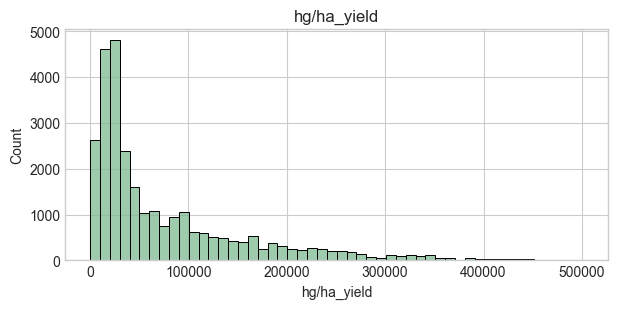

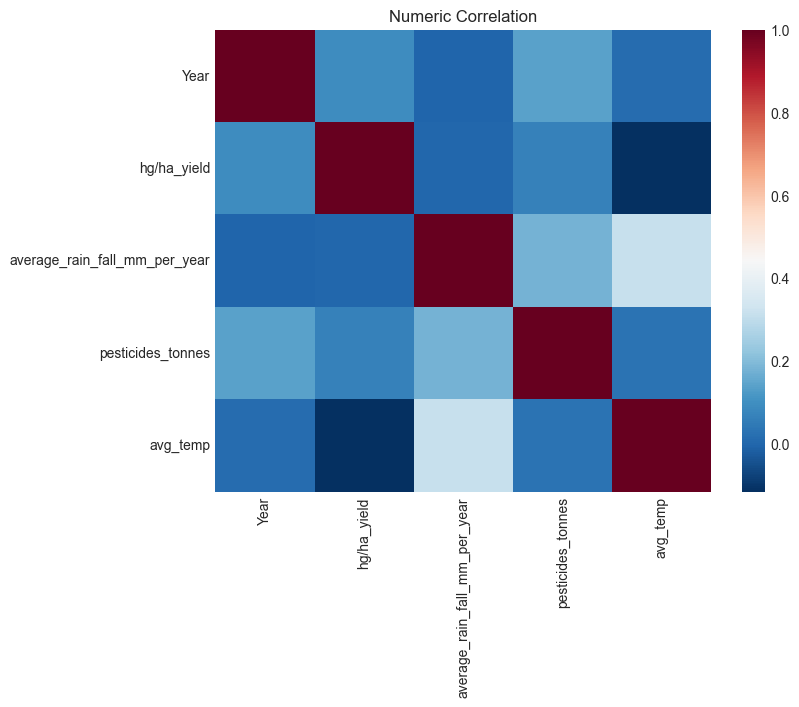

In [5]:
# Quick EDA visualizations (before any scaling/encoding)
TARGET = "hg/ha_yield"
assert TARGET in df.columns, f"Target {TARGET} missing"
y = df[TARGET].astype(float)
print("Target summary:")
display(y.describe())
plt.figure(figsize=(7,3)); sns.histplot(y,bins=50); plt.title(TARGET); plt.show()

# numeric correlation heatmap (select numeric columns)
num_cols_eda = [c for c in df.columns if df[c].dtype.kind in 'fi']
if len(num_cols_eda) > 1:
    plt.figure(figsize=(8,6)); sns.heatmap(df[num_cols_eda].corr(), annot=False, cmap='RdBu_r'); plt.title("Numeric Correlation"); plt.show()


#Define features, encode, standardize, and split (this ensures clean NUM_COLS)
This cell recomputes clean lists and performs train/test split. It excludes any target/derived columns from features.

In [6]:
# Feature selection, label encoding for NN embeddings, and train/test split
CAT_COLS = [c for c in ["Area","Item"] if c in df.columns]
# exclude target and label-encoders etc.
exclude = set(CAT_COLS + ["Year", TARGET, "target_raw", "target_log1p"])
# choose numeric candidates
num_cands = [c for c in df.columns if df[c].dtype.kind in 'fi' and c not in exclude and not c.endswith("_le")]
# safe unique list
NUM_COLS = list(dict.fromkeys(num_cands))
# label encode categorical columns for NN use
label_encoders = {}
for c in CAT_COLS:
    le = LabelEncoder()
    df[c + "_le"] = le.fit_transform(df[c].astype(str))
    label_encoders[c] = le

# normalized year if present
if "Year" in df.columns:
    df["year_norm"] = (df["Year"] - df["Year"].min()) / (df["Year"].max() - df["Year"].min())
    if "year_norm" not in NUM_COLS: NUM_COLS.append("year_norm")

# targets
df["target_raw"] = df[TARGET].astype(float)
df["target_log1p"] = np.log1p(df["target_raw"] + 1e-9)

# split
train_df, test_df = train_test_split(df, test_size=0.20, random_state=SEED)
print("Train/Test shapes:", train_df.shape, test_df.shape)
print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)


Train/Test shapes: (22593, 12) (5649, 12)
NUM_COLS: ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'year_norm']
CAT_COLS: ['Area', 'Item']


#Standardize numeric features and show standardized histograms (visual pre/post scale)
This cell fits a StandardScaler on train numeric features, transforms train/test, and plots before/after for one numeric example.

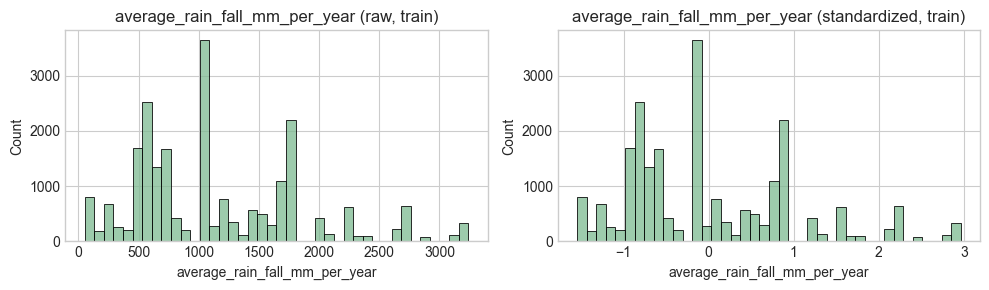

In [7]:
# Standardize numeric features and show comparison plots (before & after)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_df[NUM_COLS])
train_num_scaled = pd.DataFrame(scaler.transform(train_df[NUM_COLS]), columns=NUM_COLS, index=train_df.index)
test_num_scaled = pd.DataFrame(scaler.transform(test_df[NUM_COLS]), columns=NUM_COLS, index=test_df.index)
joblib.dump(scaler, MODELS_DIR / "scaler_nn.pkl")

# show one numeric column before and after
if NUM_COLS:
    col = NUM_COLS[0]
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); sns.histplot(train_df[col], bins=40); plt.title(f"{col} (raw, train)")
    plt.subplot(1,2,2); sns.histplot(train_num_scaled[col], bins=40); plt.title(f"{col} (standardized, train)")
    plt.tight_layout(); plt.show()
else:
    print("No numeric columns detected to standardize.")


#Build and Train the Dense Neural Network

Input dimension: 6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,801 (175.00 KB)

 Trainable params: 43,905 (171.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 60.5349 - rmse: 7.7793 - val_loss: 7.9153 - val_rmse: 2.8103 - learning_rate: 5.0000e-04
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.2163 - rmse: 1.4827 - val_loss: 1.1976 - val_rmse: 1.0862 - learning_rate: 5.0000e-04
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.3382 - rmse: 1.1491 - val_loss: 1.1858 - val_rmse: 1.0808 - learning_rate: 5.0000e-04
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.2551 - rmse: 1.1125 - val_loss: 1.1402 - val_rmse: 1.0596 - learning_rate: 5.0000e-04
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.2192 - rmse: 1.0963 - val_loss: 1.1019 - val_rmse: 1.0415 - learning_rate: 5.0000e-04
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.1867 - rmse: 1.0814 - val_loss: 1.0601 - val_rmse: 1.0213 - learning_rate: 5.0000e-04
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.1537 - rmse: 1.0661 - val_loss: 1.0689 - va

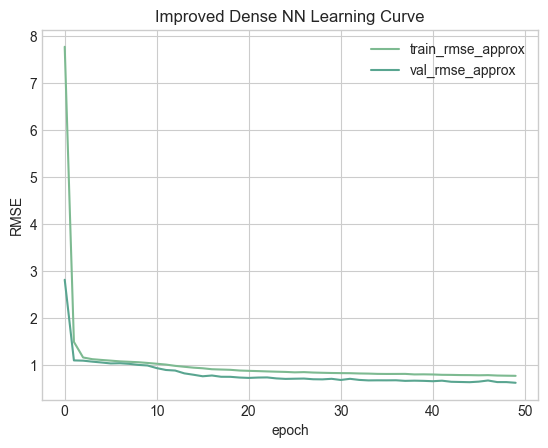

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluation Metrics: {'RMSE': 48973.96795739758, 'MAE': 28400.29057821178, 'R2': 0.6693468429333875, 'MAPE': 54.648217583041614}


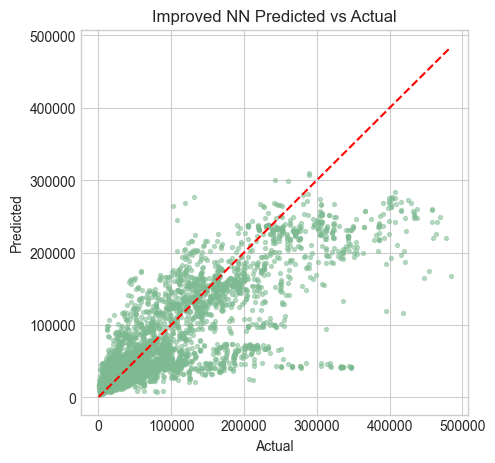

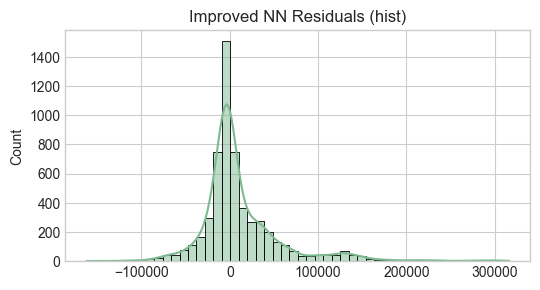

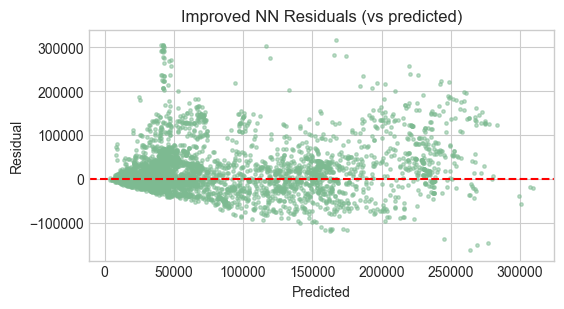

Improved model saved to: results\models\crop_prediction.h5


In [ ]:
# ===========================
# IMPROVED DENSE NEURAL NETWORK MODEL
# ===========================

# Prepare input features for NN
X_train = np.concatenate([
    train_num_scaled.values,
    train_df[[c + "_le" for c in CAT_COLS]].values
], axis=1)
X_test = np.concatenate([
    test_num_scaled.values,
    test_df[[c + "_le" for c in CAT_COLS]].values
], axis=1)

# Use log-transformed target for stability
y_train = train_df["target_log1p"].values
y_test = test_df["target_log1p"].values

input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

# ---------------------------
# Improved Model Architecture
# ---------------------------
def build_dense_nn_v2(input_dim, dropout=0.5):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        # Layer 1
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),

        # Layer 2
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),

        # Layer 3
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),

        # Output layer
        layers.Dense(1, activation='linear')  # Regression output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss='mse',
        metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

model = build_dense_nn_v2(input_dim)
model.summary()

# ---------------------------
# Training with Callbacks
# ---------------------------
EPOCHS = 50
BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stop, lr_schedule]
)

# ---------------------------
# Plot learning curve
# ---------------------------
plot_nn_learning_curve(history, title="Improved Dense NN Learning Curve")

# ---------------------------
# Evaluate on Test Set
# ---------------------------
y_pred_log = model.predict(X_test).ravel()
y_pred = np.expm1(y_pred_log)
y_true = test_df["target_raw"].values

metrics = evaluate_regression(y_true, y_pred)
print("Evaluation Metrics:", metrics)

plot_pred_vs_actual(y_true, y_pred, title="Improved NN Predicted vs Actual")
plot_residuals(y_true, y_pred, title="Improved NN Residuals")

# ---------------------------
# Save Model + Artifacts
# ---------------------------
MODEL_PATH = MODELS_DIR / "crop_prediction.keras"
model.save(MODEL_PATH)
print(f"Model saved in modern Keras format at: {MODEL_PATH}")


# Save label encoders
joblib.dump(label_encoders, MODELS_DIR / "label_encoders.pkl")
joblib.dump(scaler, MODELS_DIR / "scaler_nn.pkl")

# Log experiment
log_experiment({
    "Model": "DenseNN_v2",
    "Saved_As": "crop_prediction.h5",
    "Epochs": len(history.history['loss']),
    "RMSE": metrics["RMSE"],
    "MAE": metrics["MAE"],
    "R2": metrics["R2"],
    "MAPE": metrics["MAPE"]
})


In [9]:
from tensorflow import keras
from pathlib import Path
import joblib

MODELS_DIR = Path("results/models")

# Load model
model = keras.models.load_model(MODELS_DIR / "crop_prediction.keras")

# Load encoders (if you saved them)
label_encoders = joblib.load(MODELS_DIR / "label_encoders.pkl")

print("Model and encoders loaded successfully!")


ValueError: File not found: filepath=results\models\crop_prediction.keras. Please ensure the file is an accessible `.keras` zip file.